
### Step 1: Import necessary modules and write main functions


In [44]:
import os
import tensorflow
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import glob
import pickle
import re
tik1=time.time()


from datetime import datetime
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import decode_predictions, preprocess_input


from tensorflow.keras.layers import Input
from keras.applications.vgg19 import preprocess_input as process_vgg19
from keras.applications.xception import preprocess_input as process_xception
from keras.applications.vgg16 import preprocess_input as process_vgg16
from keras.applications.densenet import preprocess_input as process_DenseNet








from tensorflow.keras.models import Model
from keras.utils.vis_utils import plot_model
from IPython.display import Image
from sklearn.decomposition import PCA
from scipy.spatial import distance
from sklearn.neighbors import NearestNeighbors
Image.MAX_IMAGE_PIXELS = None


def fpmls_to_feature_filename(frame,projection,model_name,layer_name,sink,rv=False):
    if rv==False:
        answer='/data/scratch/rami/features/Sink_'+sink+'/'+model_name+'/'+layer_name+'/'+\
                'feature_frame_'+frame+'/projection_'+projection+'.pkl'
    elif rv==True:
        answer='/data/scratch/rami/features/Sink_'+sink+'/'+model_name+'/'+layer_name+'/'+\
                'feature_frame_'+frame+'/projection_'+projection+'_rv.pkl'
    return answer          
ans1=(fpmls_to_feature_filename('000100','3','666','vgg20','fc12'))


def fps_to_image_filename(frame,projection,sink,rv=False):
    if rv==False:
        answer='/data/scratch/rami/thicc_images/Sink_'+sink+'/movie_frame_'+frame+'/projection_'+projection+'.pkl'
    elif rv==True:
        answer='/data/scratch/rami/thicc_images/Sink_'+sink+'/movie_frame_'+frame+'/projection_'+projection+'_rv.pkl'
    return answer   
def feature_filename_to_fpmls(feature_filename):
    num = re.findall(r'\d+', feature_filename)
    sink=num[-3]
    frame=num[-2]
    projection=num[-1]    
    model_number=0
    if len(num)>3:
        model_number=num[0]

    
    if model_number=='16':
        model_name='vgg16'
    elif model_number=='19':
        model_name='vgg19'
    elif model_number=='121':
        model_name='DenseNet121'
    elif model_number=='7':
        model_name='EfficientNetB7'
    elif model_number=='3':
        model_name='InceptionV3'
    elif model_number=='200':
        model_name='ResNetRS200'
    elif 'Xception' in feature_filename:
        model_name='Xception'
    elif 'MobileNet' in feature_filename:
        model_name='MobileNet'
    else:
        print('incorrect model number extraction from filename')
    return model_name,frame,projection,sink


def feature_filename_to_image_filename(feature_filename):
    if 'rv' in feature_filename:
        rv=True
    else:
        rv=False
    m,f,p,s=feature_filename_to_fpmls(feature_filename)
    ans=fps_to_image_filename(frame=f,projection=p,sink=s,rv=rv)
    return ans


def image_filename_to_fps(image_filename):
    num = re.findall(r'\d+', image_filename)
    frame=num[-2]
    projection=num[-1]
    sink=num[-3]   
    return frame,projection,sink



### Load the Neural Network from local files
def conv_model(model_name='resnet',show_model=False,use_timing=True, layer_name='flatten'):
    t_1=time.time()
    path='/data/scratch/rami/models/'+model_name+'/'+layer_name
    model = tensorflow.keras.models.load_model(path,compile=False)
    t_2=time.time()
    if model==None:
        print('Incorrect model_name fed to function conv_model')
    elif model!=None:
        for layer in model.layers:
            layer.trainable=False
    t_3=time.time()
    if show_model==True:
        model.summary()
    t_4=time.time()
    if use_timing:
        print('Loading convolutional model:',model_name)
        print('%1.2f sec to load the model parameters'%(t_2-t_1))
        print('%1.2f sec to freeze the model layers'%(t_3-t_2))
        print('%1.2f sec to show the model parameters'%(t_4-t_3))
        
    return model


# Load a file from inside a pickle 
def load_img_from_pickles(pickle_file='/lustre/astro/rlk/Movie_frames/Ramses/Sink_91/XY/1000AU/Obs_Comp/Image_Center_Primary/Time_Series/Obs_threshold/Zoom_in/'\
                          ,model_name='vgg16'):
    file = open(pickle_file, "rb")
    image = pickle.load(file,encoding='bytes')
    file.close()
    shape_image=np.shape(image)
    image_rgb=np.zeros(shape=(shape_image[0],shape_image[1],3))
    image_rgb[:,:,0]=image
    image_rgb[:,:,1]=image
    image_rgb[:,:,2]=image
    x = np.expand_dims(image_rgb, axis=0)
    if model_name=='vgg16':  
        x=process_vgg16(x)
    elif model_name=='xception':
        x=process_xception(x)
    elif model_name=='vgg19':
        x=process_vgg19(x) 
    
    return image_rgb,x




 # Delete the neural network 
def delete_model(model, clear_session=True):
    '''removes model!
    '''
    del model
    gc.collect()
    if clear_session: K.clear_session()

def get_neighbors(feature_vector,feature_vectors, k=5,metric='euclidean'):
    '''Function that returns the neighbor distances and their indeces (of the image array corresponding to the images names)'''
    similar_idx=[]
    if metric=='braycurtis':
        similar_idx = [ distance.braycurtis(feature_vector, feat) for feat in feature_vectors ]
    elif metric=='canberra':
        similar_idx = [ distance.canberra(feature_vector, feat) for feat in feature_vectors ]
    elif metric=='euclidean':
        similar_idx = [ distance.euclidean(feature_vector, feat) for feat in feature_vectors ]
    elif metric=='chebyshev':
        similar_idx = [ distance.chebyshev(feature_vector, feat) for feat in feature_vectors ]
    elif metric=='cityblock':
        similar_idx = [ distance.cityblock(feature_vector, feat) for feat in feature_vectors ]
    elif metric=='correlation':
        similar_idx = [ distance.correlation(feature_vector, feat) for feat in feature_vectors ]
    elif metric=='cosine':
        similar_idx = [ distance.cosine(feature_vector, feat) for feat in feature_vectors ]
    elif metric=='hamming':
        similar_idx = [ distance.hamming(feature_vector, feat) for feat in feature_vectors ]
    else:
        print('Invalid distance')
#     print('After calculating the distance we have:',similar_idx)
    idx_closest = sorted(range(len(similar_idx)), key=lambda k: similar_idx[k])[0:0+k]
    distances=[]
    for i in idx_closest:
        distances.append(similar_idx[i])
    distances=np.array(distances)
    idx_closest=np.array(idx_closest)
    return distances,idx_closest        




# Load an image to the neural network
def load_image(image_path,model,model_name='resnet'):
    '''Load an image an preprocess it, and return the image and the preprocessed input'''
#     print('Model input shape:',model.input_shape[1:3])
    img = image.load_img(image_path, target_size=(224,224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    if model_name=='vgg16':  
        x=process_vgg16(x)
    elif model_name=='xception':
        x=process_xception(x)
    elif model_name=='vgg19':
        x=process_vgg19(x) 
    ##xx
    else:
        print('Incorrect  model_name fed to function load_image')
    return img, np.array(x)

def load_pickle(file='/lustre/astro/rlk/Movie_frames/Ramses/Sink_91/XY/1000AU/Obs_Comp/Image_Center_Primary/Time_Series/Obs_threshold/Zoom_in/'):
    '''Loads a pickle file simply'''
    information=open(file,"rb")
    result=pickle.load(information,encoding='bytes')
    information.close()
    return result

def load_img_from_pickles(pickle_file='/lustre/astro/rlk/Movie_frames/Ramses/Sink_91/XY/1000AU/Obs_Comp/Image_Center_Primary/Time_Series/Obs_threshold/Zoom_in/'\
                          ,model_name='vgg16'):
    file = open(pickle_file, "rb")
    image = pickle.load(file,encoding='bytes')
    #X, Y, image = pickle.load(file)
    file.close()
    shape_image=np.shape(image)
    image_rgb=np.zeros(shape=(shape_image[0],shape_image[1],3))
    image_rgb[:,:,0]=image
    image_rgb[:,:,1]=image
    image_rgb[:,:,2]=image
    x = np.expand_dims(image_rgb, axis=0)
    if model_name=='vgg16':  
        x=process_vgg16(x)
    elif model_name=='xception':
        x=process_xception(x)
    elif model_name=='vgg19':
        x=process_vgg19(x) 
    
    return image_rgb,x


#Find the convolutional feature for an image
def img_to_conv_features(model,x):
    '''Convert 1 image to its convolutional features'''
   
    feat=model.predict(x)
    feature=feat.flatten()
    return np.array(feature)

# Find the convolutional features for a set of images
def imgs_to_conv_features(model,images,model_name):

    
    tic = time.process_time()
    every=20
    features = []
    for i, images_path in enumerate(images):

        img,x = load_image(image_path=images_path,model=model,model_name=model_name)
        feat = model.predict(x)
        feature=feat.flatten()
        features.append(feature)
    
    # Timing output
    if i % every == 0:
            toc = time.process_time()
            elap = toc-tic;
            remaining_time=(len(images)-i)*elap/every
            hours=remaining_time//3600
            minutes=remaining_time//60
            seconds=remaining_time%60
            print("analyzing image %d / %d. Time/%d pics: %4.4f seconds." % (i, len(images),every,elap))
            print('Remaining time: %d hours %d minutes %d sec.' %(hours,minutes,seconds))
            
            tic = time.process_time()
   

        
    print('finished extracting features for %d images' % len(images))
    return np.array(features)

def pickles_to_conv_features(pickles,model,model_name):
       
    tic = time.process_time()
    every=20
    features = []
    for i, pickle_file in enumerate(pickles):

        img,x = load_img_from_pickles(pickle_file=pickle_file,model_name=model_name)
        feat = model.predict(x)
        feature=feat.flatten()
        features.append(feature)
    
    # Timing output
    if i % every == 0:
            toc = time.process_time()
            elap = toc-tic;
            remaining_time=(len(images)-i)*elap/every
            hours=remaining_time//3600
            minutes=remaining_time//60
            seconds=remaining_time%60
            print("analyzing image %d / %d. Time/%d pics: %4.4f seconds." % (i, len(pickles),every,elap))
            print('Remaining time: %d hours %d minutes %d sec.' %(hours,minutes,seconds))
            
            tic = time.process_time()
   
        
    print('finished extracting features for %d images' % len(pickles))
    return np.array(features)


def choose_pickles_wildcards(max_num_pickles=200, pickles_path=''):
    files=[]
    i=1
    for file in glob.glob(pickles_path):
    #     print(name)
        files.append(file)
        if i>=max_num_pickles:
            break
        i+=1
    return files
# Find the paths of all images ina folder.
def choose_imgs(max_num_images=2000,images_path='C:\\Users\\Rami\\Desktop\\PetImages\\dogs-vs-cats'):
    image_extensions = ['.jpg', '.png', '.jpeg']   # case-insensitive (upper/lower doesn't matter)
    images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames if os.path.splitext(f)[1].lower() in image_extensions]
    print(np.shape(images))
    if max_num_images < len(images):
        images = [images[i] for i in sorted(random.sample(range(len(images)), max_num_images))]

    print("keeping %d images to analyze" % len(images))
    return images


# Choose pickle files
def choose_pickles(max_num_pickles=2000,pickles_path='/lustre/astro/rlk/Movie_frames/Ramses/Sink_91/XY/1000AU/Obs_Comp/Image_Center_Primary/Time_Series/Obs_threshold/Zoom_in/'):
    pickles_extensions = ['.pkl']   # case-insensitive (upper/lower doesn't matter)
    pickles = [os.path.join(dp, f) for dp, dn, filenames in os.walk(pickles_path) for f in filenames if os.path.splitext(f)[1].lower() in pickles_extensions]
    if max_num_pickles < len(pickles):
        pickles = [pickles[i] for i in sorted(random.sample(range(len(pickles)), max_num_pickles))]

#     print("keeping %d pickles." % len(pickles))
    return pickles

def get_scores(pickles_path):
    #This function gets the folder frame and gives back a 3xN array which contains the frame number, the projection number and zeros on the last matrix (for there we will save the score)
    pickles_extensions = ['.pkl']   # case-insensitive (upper/lower doesn't matter)
    pickles = [os.path.join(dp, f) for dp, dn, filenames in os.walk(pickles_path) for f in filenames if os.path.splitext(f)[1].lower() in pickles_extensions]
    if max_num_pickles < len(pickles):
        pickles = [pickles[i] for i in sorted(random.sample(range(len(pickles)), max_num_pickles))]
    filespace=np.zeros((3,len(pickles)))
    for i,pickle_ in enumerate(pickles):
        frame=pickle_[-23:-17]
        projection=pickle_[-5:-4]
        filespace[0,i]=frame
        filespace[1,i]=projection
    return filepsace

# Reduce dimensionality of data.
def reduce_PCA(features,n_components=40):
    features = np.array(features)
    pca = PCA(n_components=n_components)
    pca.fit(features)
    pca_features = pca.transform(features)
    return pca_features

# Plot the feature vector of a network
def plot_activation_layer(feature_vector):
    
    print(np.shape(feature_vector))
    feature_vector=np.array(feature_vector)
    feature_vector=feature_vector.flatten()
    plt.figure(figsize=(16,4))
    plt.ylabel('Activations of last layer (fc2)')
    plt.xlabel('## of neuron')
    plt.plot(feature_vector)
    plt.show()
    plt.close()
    
    return 0

def plot_img_from_pickles(pickle_file='',title=None, \
                          power=0.1):
    file = open(pickle_file, "rb")
    image = pickle.load(file,encoding="ASCII")
    #X, Y, image = pickle.load(file)
    file.close()
    shape_image=np.shape(image)
    image_rgb=np.zeros(shape=(shape_image[0],shape_image[1],3))
    image_rgb[:,:,0]=image
    image_rgb[:,:,1]=image
    image_rgb[:,:,2]=image
    image_before_preprocess=np.expand_dims(image_rgb, axis=0)
    plt.figure(figsize=(10,10))
    if title!=None:
        plt.title(title)
    plt.imshow(image**power,cmap='magma')
    return 0



# Plot best 5 matches function
def get_concatenated_images(indexes,images, thumb_height):
    thumbs = []
    for idx in indexes:
        img = image.load_img(images[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image

tik2=time.time()

print('Cell run time=',(tik2-tik1))

Cell run time= 0.005269527435302734


In [53]:

tik1=time.time()

def Image_search_v2(pickle_path='/data/scratch/rami/features/Sink_91/vgg16/block4_pool/feature_frame000109/projection_4.pkl', \
                 pickles_path='/data/scratch/rami/features/Sink_49/vgg16/block4_pool/feature_frame_000201/projection_?.pkl',max_num_pickles=20,\
                 model_name='vgg16', layer_name='block4_pool',\
                 metric='euclidean',k=5,use_PCA=False,n_components=500,\
                 use_timing=False,display_output=True,\
                 save_best_matches=False, best_matches_folder='/lustre/hpc/astro/rami/images/'):
    
            
            
    ### Load OBSERVATION feature pickle file.
    feature = load_pickle(file=pickle_path)



    # Get the paths of feature vectors.
    feature_files=choose_pickles_wildcards(max_num_pickles=max_num_pickles,pickles_path=pickles_path)
    print('found ', len(feature_files),' pickles')
        
  # Create an array containing all features
    features=[]
    for i, pickle_file in enumerate(feature_files):
        feat= load_pickle(file=pickle_file)
        features.append(feat)
    features=np.array(features)    
    print("Shape of features:",np.shape(features))
    print('\n')
    print("Shape of feature:",np.shape(feature))
    print('\n')

    
    ### Calculate distances    
    distances,idx_closest=get_neighbors(feature,features,k=k,metric=metric)
    distances=np.array(distances)
    print('distances shape:',np.shape(distances))
    print('neighbour indeces with closest distances with respect to:%s'%pickle_path)
    print('for neighbors with indexes respectively:')
    print(idx_closest)
    print('\n')
    print(len(np.where(distances[:]==0)))
    i=0
    names=[]
    # For the closest neighbors save their name in the names list defined above
    for idx in idx_closest:
        if i>k:
            print("i was found greater than k. Breaking the loop")
            break
        
        name=feature_files[idx]
        # print('name of ',i+1,'closest:',name,distances[i])
        i+=1
        names.append(name)
    num = re.findall(r'\d+', pickles_path)
    sink_pickles=num[0]
    path_reggie='/data/scratch/rami/thicc_images/Sink_'+sink_pickles

    
    ### Plot the best matches
        
        
    #Plot the observation
    
    title='Submm 1.2mm'
    obs_file='/data/scratch/rami/images/Observation/submm.pkl'
    
    if display_output:
        plot_img_from_pickles(pickle_file=obs_file,power=1,title=model_name)
        plot_width=4
        plot_height=k//4

        fig = plt.figure(figsize=(20, int((30*k)//20)))
    #Plot and print the best matches
    j=1
    names_output=[]
    distances_output=[]
    #loop over the best k matches
    for match in  names:
        #obtain the image location in disk
        file=feature_filename_to_image_filename(match)
        # save the distance between observation and j-th best match.
        distances_output.append(distances[j-1])
        names_output.append(file)
        print(j,'best match:',file)
        if display_output:
            ax = fig.add_subplot(plot_height,plot_width,j)
        img=load_pickle(file=file)
        frame,projection,sink=image_filename_to_fps(match)
        title='movie frame:%s \n projection %s \n sink %s \n'%(frame,projection,sink)+str(j)+' best match,\n distance=%1.8e'%distances[j-1]
        if display_output:
            plt.title(title)
#         print(np.shape(img))
        if display_output:
            ax.imshow(img,cmap='magma')
#                 plt.imshow(img**0.1)
        if save_best_matches:
            fig.savefig('best_matches%s.png'%model_name, dpi=100)
        j+=1

    if use_timing:
        t6 = time.time()    
        


    # Timing outputs
    ###########################################################################
    if use_timing:
        Dt1=t1-t0
        Dt2=t2-t1
        Dt3=t3-t2
        Dt4=t4-t3
        Dt5=t5-t4
        Dt6=t6-t5

        print('\n')
        print('\n')
        print('Dt1=%3.3f s:Model parameter loading: '%Dt1)

        print('Dt2=%3.3f s:1) Image preprocessing and 2)loading of feature calculator 3) feature calculation for one image'%Dt2)
        print('\n Of which: \n')
        print('%.2f s  for loading image'%(t11-t1))
        print('%.2f s  for calculating convolutional features'%(t13-t12))


        print('Dt3=%3.3f s:Choosing the images from the folder:'%Dt3)
        print('Dt4=%3.3f s:Images to convolutional features for %d images'%(Dt4,max_num_images))
        print('Dt5=%3.3f s:PCA '%Dt5)
        print('Dt6=%3.3f s:K nearest neighbohrs'%Dt6)
        print('\n')
        print('\n')
#     for i in range(np.shape(features)[0]):
#         if i%100==0:
#             if (features[0,:]==features[i,:]).all():
# #                 print('feature vectors 0 and %d are the same'%i)
    return names_output,np.array(distances_output)

tik2=time.time()

print('Cell run time=',(tik2-tik1))

Cell run time= 0.0006582736968994141


In [54]:
# tik1=time.time()
# models=[  'DenseNet121', 'EfficientNetB7',  'ResNetRS200', 'MobileNet',      'vgg16','vgg19',  'InceptionV3' ,  'Xception' ]
# for model_name in models:
#     best_matches1=Image_search_v2( pickle_path='/data/scratch/rami/features/large_models/'+model_name+'/observation.pkl',\
#                 pickles_path='/lustre/astro/rami/features/large_models/'+model_name+'/Sink_*/feature_frame_00????/projection_?.pkl',\
#                 max_num_pickles=100,\
#                  model_name=model_name,
#                  metric='euclidean',k=20,use_PCA=False,n_components=500,\
#                  use_timing=False,display_output=True,\
#                  save_best_matches=False, best_matches_folder='/lustre/hpc/astro/rami/images/')



# tok=time.time()
# print('time of execution',tok-tik1)

# print(best_matches1)


found  100  pickles
Shape of features: (100, 100)


Shape of feature: (100,)


distances shape: (20,)
neighbour indeces with closest distances with respect to:/data/scratch/rami/features/large_models/DenseNet121_trained/observation.pkl
for neighbors with indexes respectively:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


1
1 best match: /data/scratch/rami/thicc_images/Sink_49/movie_frame_002006/projection_4.pkl
2 best match: /data/scratch/rami/thicc_images/Sink_49/movie_frame_002006/projection_3.pkl
3 best match: /data/scratch/rami/thicc_images/Sink_49/movie_frame_002006/projection_2.pkl
4 best match: /data/scratch/rami/thicc_images/Sink_49/movie_frame_002006/projection_5.pkl
5 best match: /data/scratch/rami/thicc_images/Sink_49/movie_frame_002006/projection_6.pkl
6 best match: /data/scratch/rami/thicc_images/Sink_49/movie_frame_002006/projection_1.pkl
7 best match: /data/scratch/rami/thicc_images/Sink_49/movie_frame_002006/projection_0.pkl
8 best match: /data/scratch

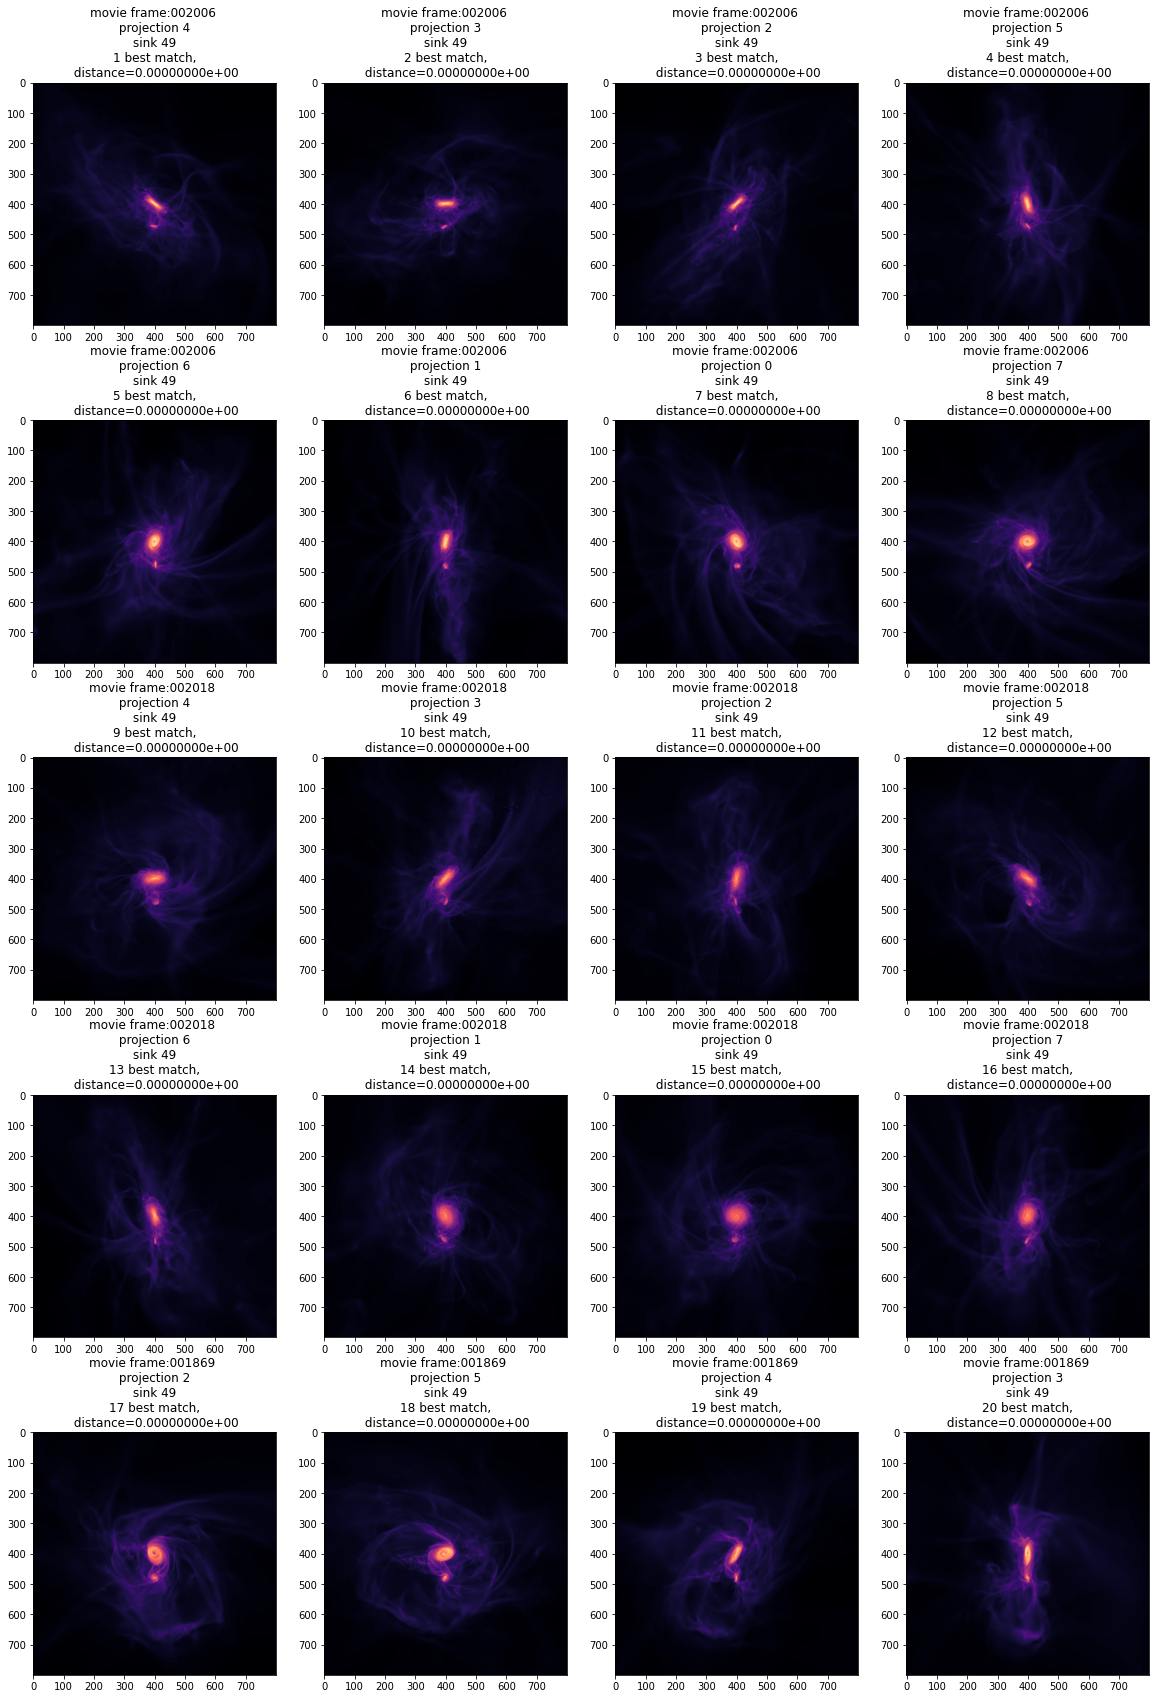

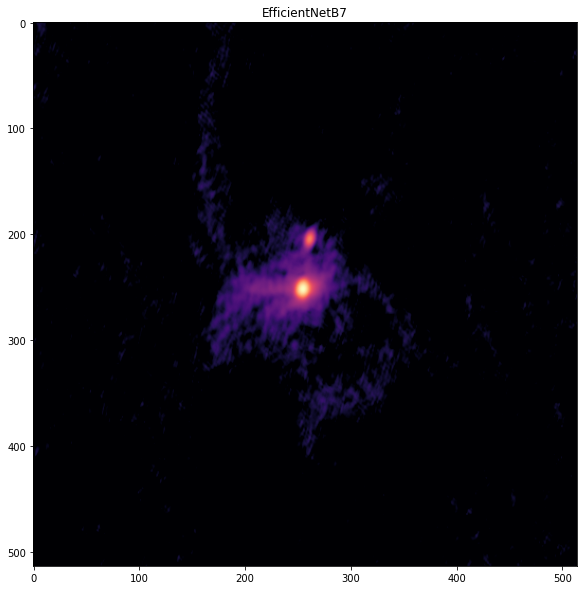

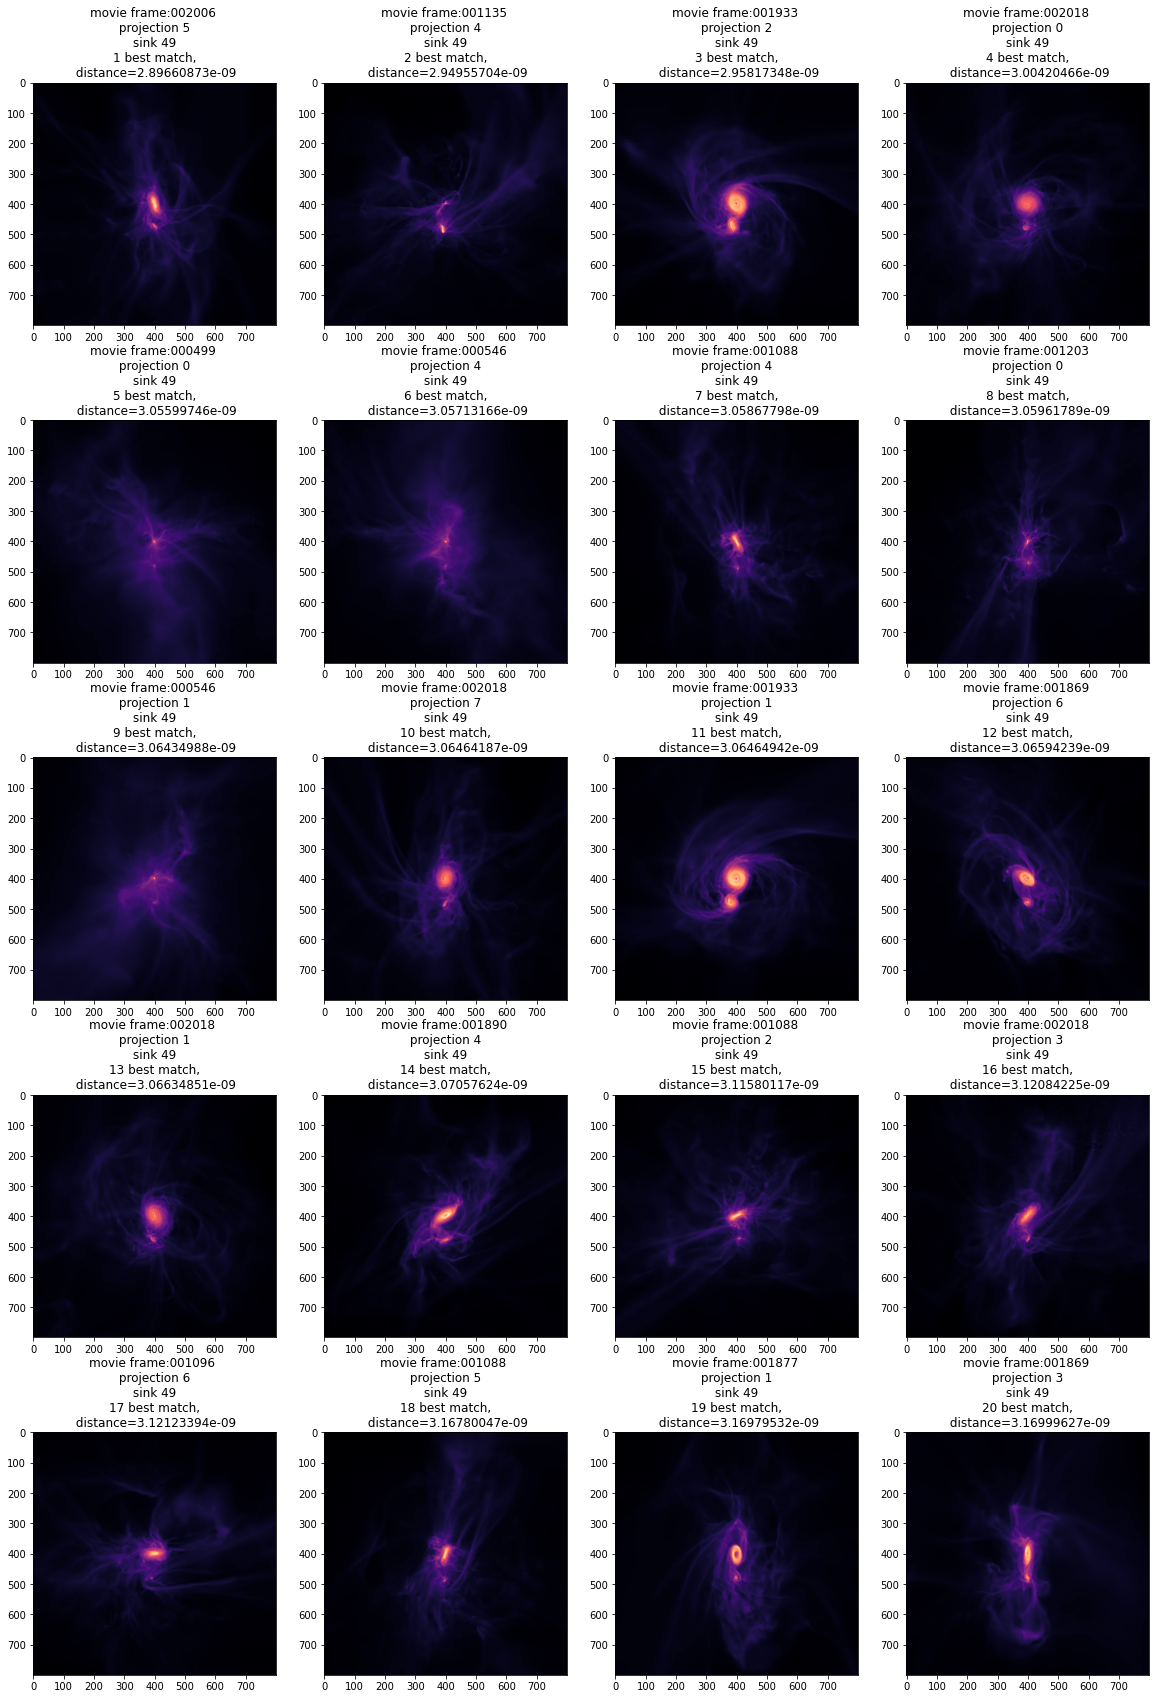

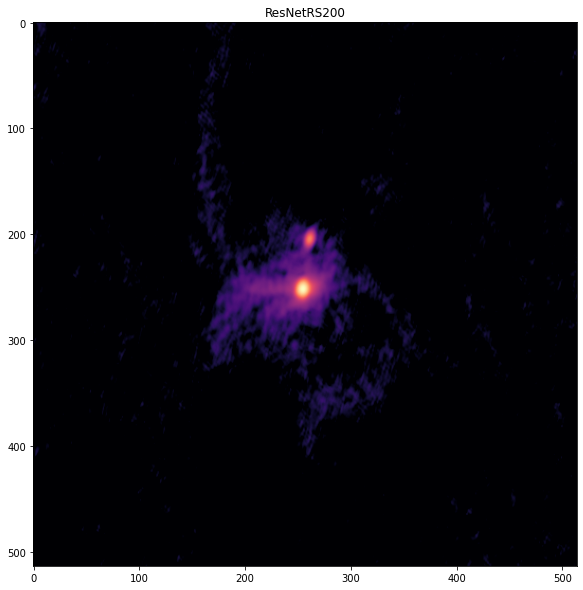

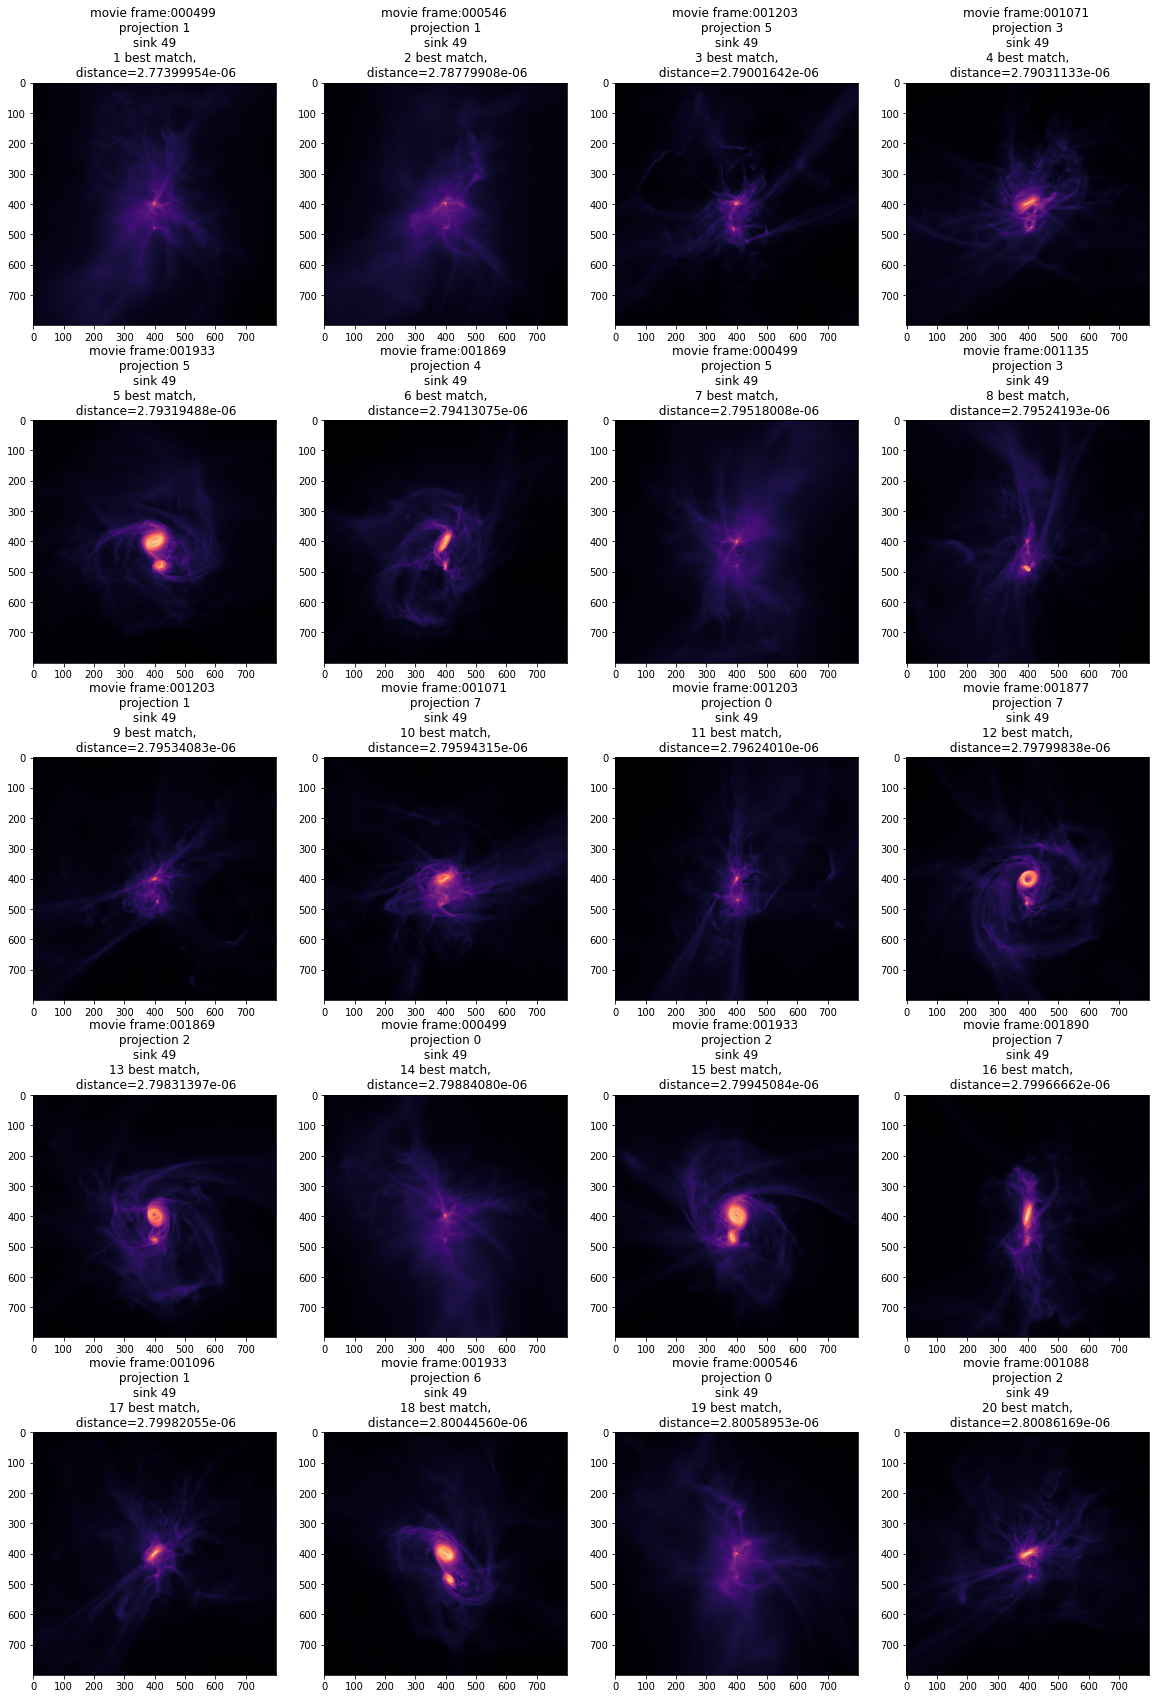

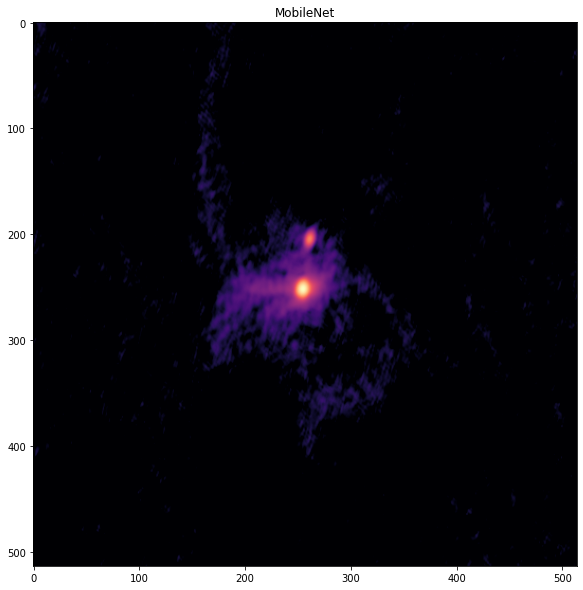

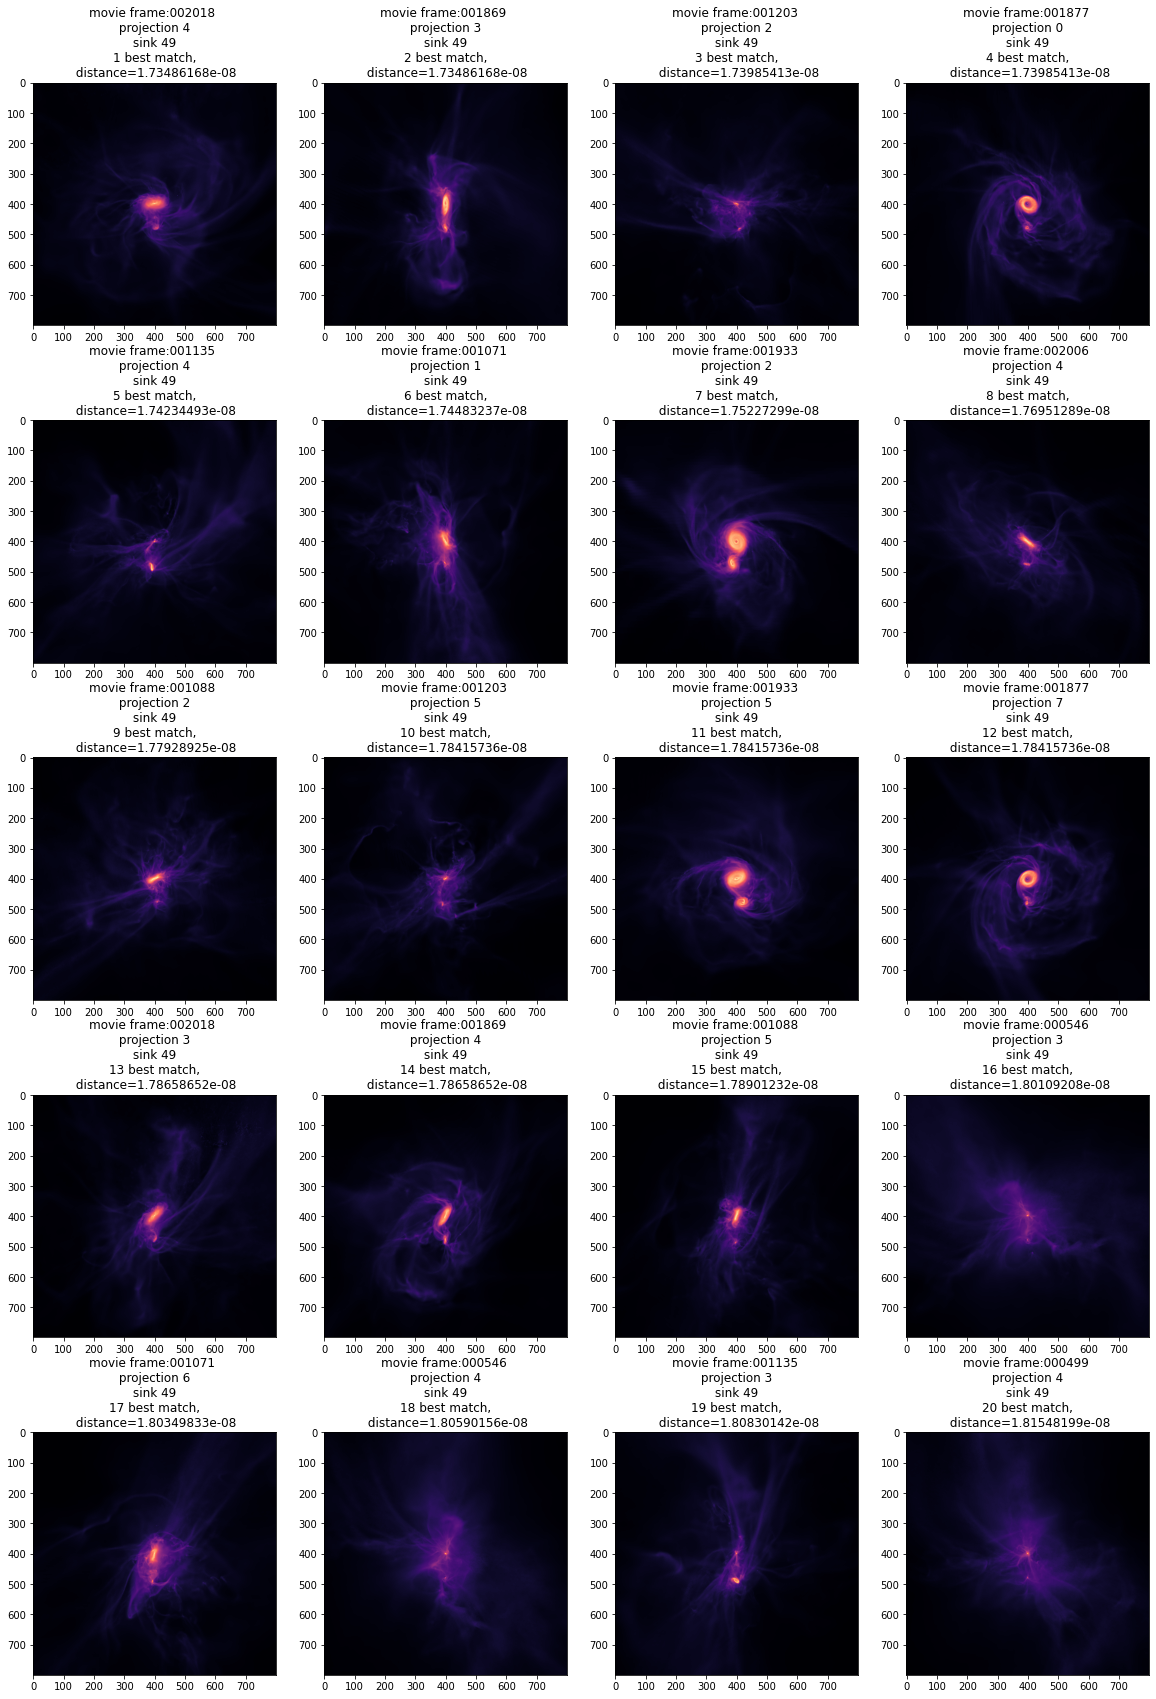

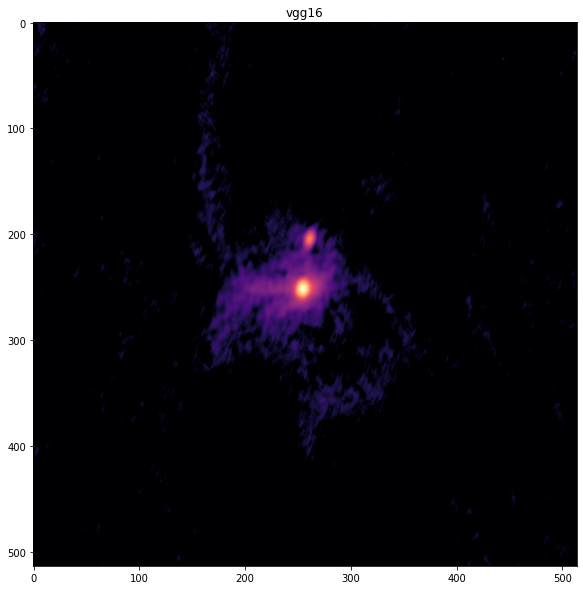

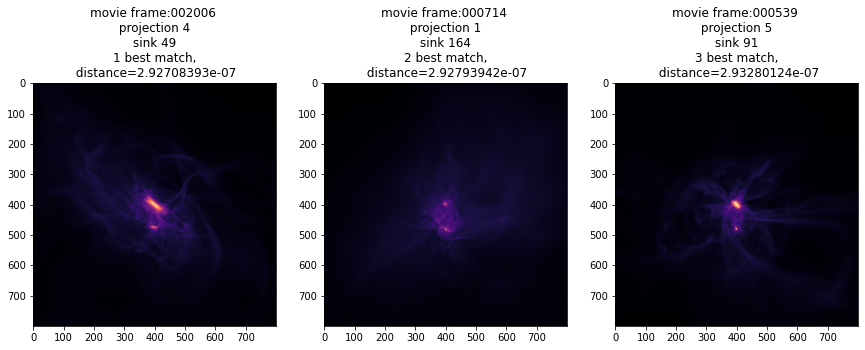

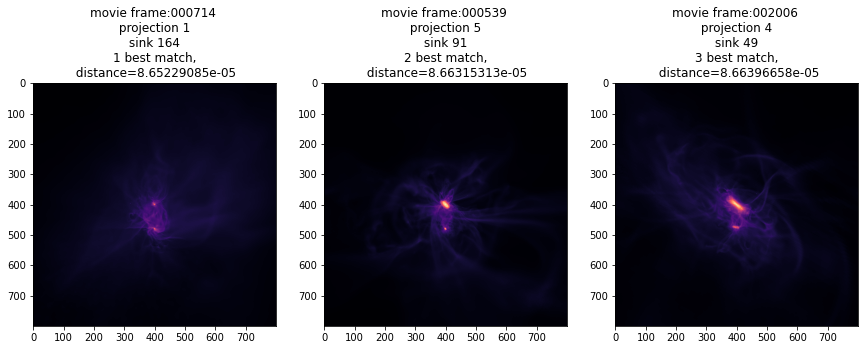

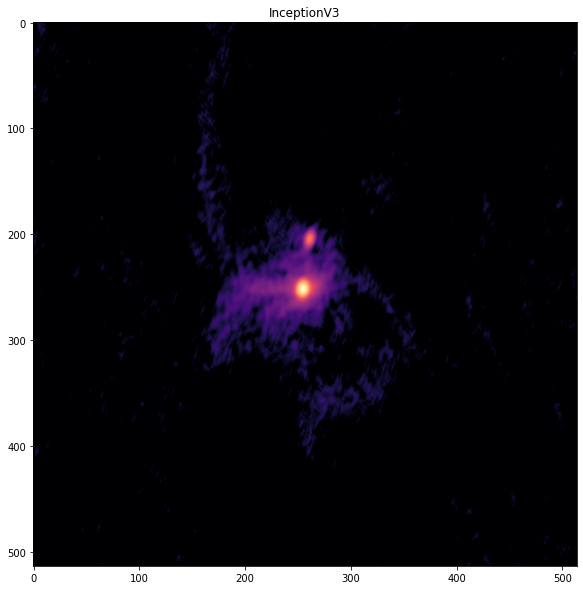

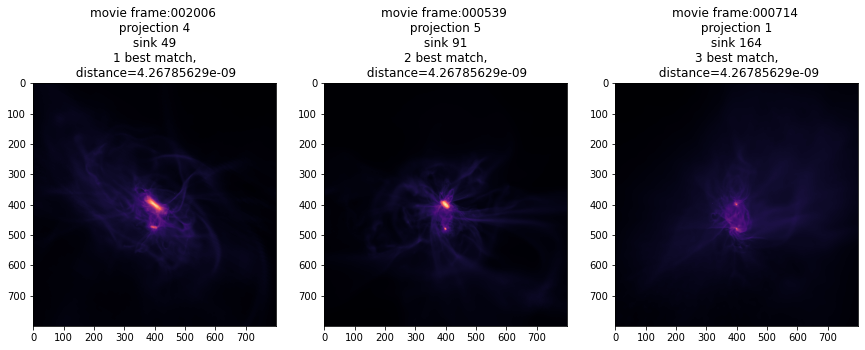

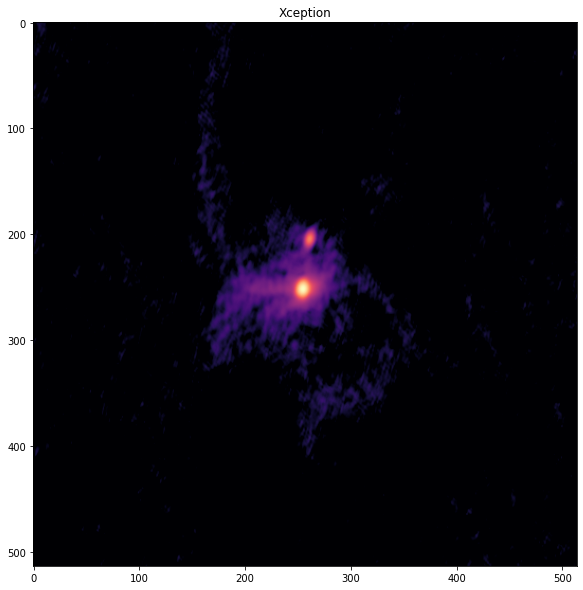

In [55]:
tik1=time.time()
models=[  'DenseNet121', 'EfficientNetB7',  'ResNetRS200', 'MobileNet',      'vgg16','vgg19',  'InceptionV3' ,  'Xception' ]
for model_name in models:
    best_matches1=Image_search_v2( pickle_path='/data/scratch/rami/features/large_models/'+model_name+'_trained/observation.pkl',\
                pickles_path='/data/scratch/rami/features/large_models/'+model_name+'_trained/Sink_*/feature_frame_00*/projection_*.pkl',\
                max_num_pickles=100,\
                 model_name=model_name,
                 metric='euclidean',k=20,use_PCA=False,n_components=500,\
                 use_timing=False,display_output=True,\
                 save_best_matches=False, best_matches_folder='/lustre/hpc/astro/rami/images/')



tok=time.time()
print('time of execution',tok-tik1)

print(best_matches1)


In [19]:
# #   data/scratch/rami/features/Sink_49/vgg19/fc1/feature_frame_000202/projection_5.pkl  


from matplotlib import collections  as mc



#get the scoreboard of distances between observation on pickle_path and simulations on pickles_path.

def get_score_board(sink_pickles='49',\
                    max_num_pickles=3072,k=3072,\
                    model_names=['vgg16'],metrics=['euclidean'],\
                    display_histograms=True,save_histograms=True):
    
    # Initialize matrixes names_board which contains all names upon the search is done
   

    images_path='/data/scratch/rami/thicc_images/Sink_'+sink_pickles+'/movie_frame_00????/projection_?.pkl'
    names_board=choose_pickles_wildcards(max_num_pickles=max_num_pickles,pickles_path=images_path)
    names_board=np.array(names_board)
    #shape y expresses the number of distance measures, by combining 
    # neural network used,layer used, distance measure
    shape_y=np.shape(metrics)[0]*np.shape(model_names)[0]
    #initialize matrix score_board which will contain the distances of observation with pickles for 
    #all possible combinations of neural networks, layers and metrics.
    score_board=np.zeros(shape=(np.shape(names_board)[0],shape_y))

    i_=0
    if display_histograms==True:
    # Set plot dimensions and amount of subplots (histograms)
        plot_height=max(shape_y//4,1)
        plot_width=4
        fig,axs = plt.subplots(plot_height,plot_width,figsize=(20,int((30*shape_y)//20)))
    for model_name in model_names:
        for metric in metrics:
            pickle_path='/data/scratch/rami/features/large_models/'+model_name+'/observation.pkl'
            pickles_path='/lustre/astro/rami/features/large_models/Sink_'+sink_pickles+'/'+model_name+'/'+'feature_frame_00????/projection_?.pkl'
        
            print('correct paths : ', pickle_path,'\n',pickles_path)
            #For a specific combination of neuralnet,layer,metric search through the names_board
            names,distances_before=Image_search_v2( pickle_path='/data/scratch/rami/features/large_models/'+model_name+'/observation.pkl',\
                                    pickles_path='/lustre/astro/rami/features/large_models/'+model_name+'/Sink_49/feature_frame_00????/projection_?.pkl',\
                                    max_num_pickles=max_num_pickles,\
                                     model_name=model_name,
                                     metric=metric,k=k,use_PCA=False,n_components=500,\
                                     use_timing=False,display_output=False,\
                                     save_best_matches=False, best_matches_folder='/lustre/hpc/astro/rami/images/')

            #best matches image filenames
            names=np.array(names)

            # normalization of distances in 0-1.
            distances=distances_before/np.amax(distances_before)
            distances=np.array(distances)
            print('top 10')
            print(names[:10])
            print(distances[:10])
#                 print('printing distances')
#                 for dist in distances:
#                     print('dist:',dist)

            print('shapes of names, distances, names_board,scoreboard:',np.shape(names),np.shape(distances),np.shape(names_board),np.shape(score_board))
            for _,name in enumerate(names):
#                     print(_,'name',name)
                idx=np.where(names_board==name)
#                     print('names_board[idx]=',names_board[idx],'wow')
                score_board[idx,i_]=distances[_]
            print(model_name,metric)
            plots_num=shape_y
            
            if display_histograms==True:   
#                     print(np.shape(score_board))
                # best=5
#                     for ind in range(best):
#                         print('%d best: %s,\n \t  model=%s,\n \t  layer=%s\n \t  metric:%s\n \t  distance=%f'%(ind,names[ind],model_name,layer_name,metric,distances[ind]))
                print(i_//plot_width,i_%plot_width)
                print(score_board[i_])
                print(axs)
                axs[i_//plot_width,i_%plot_width].hist(score_board[i_],bins=100,range=(0,1))

                
#                     axs[i_//plot_width,i_%plot_width].set_ylabel('## No of counts')
#                     axs[i_//plot_width,i_%plot_width].set_xlabel('Distance')
#                     axs[i_//plot_width,i_%plot_width].set_yscale('log')
                title=metric+':'+model_name
                axs[i_//plot_width,i_%plot_width].set_title(title)


            i_+=1
    if save_histograms==True:
        fig.savefig("histograms_new_1_8.jpeg")
    fig.tight_layout()
    plt.show()
    
    return score_board,names_board

    

In [ ]:
get_score_board(sink_pickles='91',\
                    max_num_pickles=8000,k=8000,\
                    model_names=['vgg16','vgg19'],metrics=['euclidean','cosine'],\
                    display_histograms=True,save_histograms=True)

correct paths :  /data/scratch/rami/features/large_models/vgg16/observation.pkl 
 /lustre/astro/rami/features/large_models/Sink_91/vgg16/feature_frame_00????/projection_?.pkl


In [ ]:
# print(score[:10,:10])
# print(names[:10])

In [ ]:
def collapse_score_1D(names,score,k=None):
    if k==None:
        k=len(names)
    elif k>=len(names):
        k=len(names)
    distances=[]

    for i in range(np.shape(score)[0]):
        dist=np.linalg.norm(score[i,:])
        distances.append(dist)
    distances=np.array(distances)
    names=np.array(names)

#     print(names[:1000])
#     print(distances[:1000])
    names_sorted = [x for _,x in sorted(zip(distances,names))]
    distances=sorted(distances)
#     print(names[:100])
    
#     print(distances[:100])
    similarities=[]
    for i in range(k):
        similarity=100*(1-distances[i]/np.sqrt(np.shape(score)[1]))
        similarities.append(similarity)
#         print('%2.2f'%similarity,'% similarity with ',names_sorted[i])
    similarities=np.array(similarities)
    return names_sorted[:k],similarities[:k]
# names_sorted,similarities=collapse_score_1D(names,score,k=100)

In [ ]:
 #Plot the observation.
    #Optimally done if the amount of best matches inserted is a multiple of 4
def plot_best_matches(matches_names,observation,match_distances,save=True,power=0.1):
    
#     frame_pickle,projection_pickle,sink_pickle=image_filename_to_fps(observation)
    
#     title='movie frame:%s \n projection %s \n sink %s \n'%(frame_pickle,projection_pickle,sink_pickle)+'Observation'
    
    plot_img_from_pickles(pickle_file=observation,power=power,title='')
    k=len(matches_names)
    plot_width=4
    plot_height=k//4

    fig = plt.figure(figsize=(20, int((30*k)//20)))
    #Plot and print the best matches
    j=1
    #loop over the best k matches
    for match in  matches_names:
        
        ax = fig.add_subplot(plot_height,plot_width,j)
        img=load_pickle(match)
        frame,projection,sink=image_filename_to_fps(match)
        title='movie frame:%s \n projection %s \n sink %s \n'%(frame,projection,sink)+str(j)+' Similarity: :%2.1f %%'%match_distances[j-1]
#         if display_output:
        plt.title(title)
#         print(np.shape(img))

        ax.imshow(img**power,cmap='magma')
#                 plt.imshow(img**0.1)
        j+=1
    fig.tight_layout()
    if save:
        fig.savefig('best_matches.jpeg',dpi=100)
    plt.show()
    return 0
# plot_best_matches(names_sorted,'/data/scratch/rami/images/rescaled_Sink_49/movie_frame_000521/projection_3.pkl',similarities)

In [ ]:
# plot_img_from_pickles(pickle_file='/lustre/astro/rlk/Image_only_pickles/Sink_91_HR/movie_frame_000105/projection_2.pkl',title=None, power=0.1)

In [ ]:
max_num_pickles=33610
k=33610


######################################################################################################################

model_names=['vgg16','vgg19']
#layers from models to use
layer_names=['block5_pool','block4_pool']
#metrics to measure distance
metrics=['euclidean','canberra','correlation','cosine']

# metrics=['euclidean','braycurtis','canberra','chebyshev','cityblock','correlation','cosine','hamming']
# metrics=['cosine','euclidean']
# metrics=['euclidean']
# Observation
sink_pickle='164'
frame='0008888468'
projection='0'
rv=False
# Simulations
sink_pickles='91'

#####################################################################################################################
# Calculate distances for all combinations of above parameters

observation='/data/scratch/rami/images/Observation/submm.pkl'
score,names=get_score_board(sink_pickle=sink_pickle,frame=frame,projection=projection,sink_pickles=sink_pickles, max_num_pickles=max_num_pickles,k=k,\
                            model_names=model_names,layer_names=layer_names,metrics=metrics,\
                    display_histograms=True,save_histograms=True,rv=rv)

# Reduce the information of distances on a single similarity index
names_sorted,similarities=collapse_score_1D(names,score,k=k)
saved_file=[]
for _,i in enumerate(names_sorted):     
    num = re.findall(r'\d+', i)
    sink=num[0]
    frame=num[1]
    projection=num[2]
    output=np.array([sink,frame,projection,similarities[_]])
    saved_file.append(output)
output=np.array(output)
savename='/data/scratch/rami/best_matches/best_%s.pkl'%(sink)
with open(savename, 'wb') as f:
    pickle.dump(saved_file, f)
l=len(names)
#Display best matches
plot_best_matches(names_sorted[:24],observation,similarities[:24],power=0.01)

In [ ]:
max_num_pickles=33610
k=33610


######################################################################################################################

model_names=['vgg16','vgg19']
#layers from models to use
layer_names=['block5_pool','block4_pool']
#metrics to measure distance
metrics=['euclidean','canberra','correlation','cosine']

# metrics=['euclidean','braycurtis','canberra','chebyshev','cityblock','correlation','cosine','hamming']
# metrics=['cosine','euclidean']
# metrics=['euclidean']
# Observation
sink_pickle='164'
frame='0008888468'
projection='0'
rv=False
# Simulations
sink_pickles='49'

#####################################################################################################################
# Calculate distances for all combinations of above parameters

observation='/data/scratch/rami/images/Observation/submm.pkl'
score,names=get_score_board(sink_pickle=sink_pickle,frame=frame,projection=projection,sink_pickles=sink_pickles, max_num_pickles=max_num_pickles,k=k,\
                            model_names=model_names,layer_names=layer_names,metrics=metrics,\
                    display_histograms=True,save_histograms=True,rv=rv)

# Reduce the information of distances on a single similarity index
names_sorted,similarities=collapse_score_1D(names,score,k=k)
saved_file=[]
for _,i in enumerate(names_sorted):     
    num = re.findall(r'\d+', i)
    sink=num[0]
    frame=num[1]
    projection=num[2]
    output=np.array([sink,frame,projection,similarities[_]])
    saved_file.append(output)
output=np.array(output)
savename='/data/scratch/rami/best_matches/best_%s.pkl'%(sink)
with open(savename, 'wb') as f:
    pickle.dump(saved_file, f)
l=len(names)
#Display best matches
plot_best_matches(names_sorted[:24],observation,similarities[:24],power=0.01)

In [ ]:
max_num_pickles=33610
k=33610


######################################################################################################################

model_names=['vgg16','vgg19']
#layers from models to use
layer_names=['block5_pool','block4_pool']
#metrics to measure distance
metrics=['euclidean','braycurtis','canberra','correlation','cosine','hamming']

# metrics=['euclidean','braycurtis','canberra','chebyshev','cityblock','correlation','cosine','hamming']
# metrics=['cosine','euclidean']
# metrics=['euclidean']
# Observation
sink_pickle='164'
frame='0008888468'
projection='0'
rv=False
# Simulations
sink_pickles='164'

#####################################################################################################################
# Calculate distances for all combinations of above parameters

observation='/data/scratch/rami/images/Observation/submm.pkl'
score,names=get_score_board(sink_pickle=sink_pickle,frame=frame,projection=projection,sink_pickles=sink_pickles, max_num_pickles=max_num_pickles,k=k,\
                            model_names=model_names,layer_names=layer_names,metrics=metrics,\
                    display_histograms=True,save_histograms=True,rv=rv)

# Reduce the information of distances on a single similarity index
names_sorted,similarities=collapse_score_1D(names,score,k=k)
saved_file=[]
for _,i in enumerate(names_sorted):     
    num = re.findall(r'\d+', i)
    sink=num[0]
    frame=num[1]
    projection=num[2]
    output=np.array([sink,frame,projection,similarities[_]])
    saved_file.append(output)
output=np.array(output)
savename='/data/scratch/rami/best_matches/best_%s.pkl'%(sink)
with open(savename, 'wb') as f:
    pickle.dump(saved_file, f)
l=len(names)
#Display best matches
plot_best_matches(names_sorted[:24],observation,similarities[:24],power=0.01)

In [ ]:
print(paths[0])
x=paths[0]
print(x)

In [ ]:
num = re.findall(r'\d+', x)
print(num)
sink=num[0]
frame=num[1]
projection_number=num[2]


In [ ]:
x=load_pickle('/data/scratch/rami/best_matches/best_91.pkl')

In [ ]:
for i in x:
    print(i)

In [32]:
# message='Hello world'
# for i in range(5):
#     for j in range(5):
#         print(i,j)
#         print(message)
        
animals=['cats','dogs','cows']

numbers=[0,1,2,3,4]

for animal in animals:
    for number in numbers:
        print('I have ', number,' ',animal)

I have  0   cats
I have  1   cats
I have  2   cats
I have  3   cats
I have  4   cats
I have  0   dogs
I have  1   dogs
I have  2   dogs
I have  3   dogs
I have  4   dogs
I have  0   cows
I have  1   cows
I have  2   cows
I have  3   cows
I have  4   cows


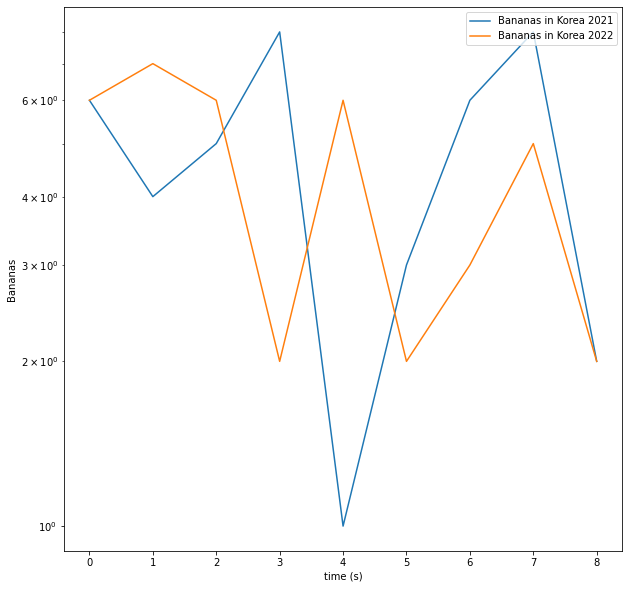

In [43]:
import matplotlib.pyplot as plt


x=[0,1,2,3,4,5,6,7,8]
y=[6,4,5,8,1,3,6,8,2]
y2=[6,7,6,2,6,2,3,5,2]

plt.figure(figsize=(10,10))
plt.plot(x,y,label='Bananas in Korea 2021')
plt.plot(x,y2,label='Bananas in Korea 2022')

# plt.yscale('log')

plt.ylabel('Bananas')
plt.xlabel('time (s)')
plt.legend(loc='upper right')

plt.text(3,5,'